## Reinforcement Learning

#### Importing Necessary Packages:

In [2]:
import random
import copy
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib.cm import get_cmap
mpl.rc('image', cmap='viridis')
%matplotlib inline
random.seed(42)

Setting up the environment:

In [2]:
walls = [[1,3],
         [1,4],
         [1,5],
         [1,6],
         [1,2],
         [2,6],
         [3,6],
         [4,6],
         [5,6],
         [7,2],
         [7,3],
         [7,4],
         [7,5]]

treasure = [8,8]
snake_pit = [6,5]

Let's start with our agent:

In [3]:
class Agent(object):
    def __init__(self,init_y,init_x):
        self.pos = [init_y,init_x]
        self.reward = 0

    def select_e_greedily(self, Qmat, e = 0.2):
        [y,x] = self.pos
        choices = Qmat[y][x]
        if np.random.uniform(0,1) < e:
            # Select random move
            return np.random.choice(list(choices.keys()))
        else:
            # Select highest Q move
            return max(choices, key=choices.get)

    def move(self, dir, walls, size):
        new_pos = copy.copy(self.pos)

        if dir == 'north':
            new_pos[0] += -1
        elif dir == 'south':
            new_pos[0] += 1
        elif dir == 'east':
            new_pos[1] += 1
        elif dir == 'west':
            new_pos[1] += -1

        # Check if bumped against a wall or out-of bounds
        bumped = new_pos in walls or \
                 new_pos[0] < 0 or \
                 new_pos[0] >= size or \
                 new_pos[1] < 0 or \
                 new_pos[1] >= size

        if not bumped:
            self.pos = new_pos

        return self.pos

Next we create our Gridworld class:

In [4]:
class Gridworld(object):
    def __init__(self,walls, treasure, snake_pit, size = 9, alfa=0.5, gamma = 1):
        self.size = size
        self.walls = walls
        self.treasure = treasure
        self.snake_pit = snake_pit
        self.snake_penalty = -50
        self.treasure_reward = 50
        self.default_reward = -1
        self.alfa = alfa
        self.gamma = gamma

        # Initialize random policies
        self.policies = [
            [{'north': 0.25,
              'south': 0.25,
              'west': 0.25,
              'east': 0.25}
             for _ in range(size)]
             for _ in range(size)]

        # Initialize Q values to 0
        self.Qmat = [[
            {'north': 0.,
             'south': 0.,
             'east': 0.,
             'west': 0.}
            for _ in range(self.size)]
            for _ in range(self.size)]

    def init_agent(self):
        '''
        Initializes the agent in a tile that is not a wall.
        '''
        [start_y,start_x] = self.walls[0]
        while [start_y,start_x] in self.walls:
            start_y = random.randint(0,self.size-1)
            start_x = random.randint(0,self.size-1)

        self.agent = Agent(start_y, start_x)


    def check_reward(self, current_pos):
        '''
        Checks reward associated at a position
        '''
        if current_pos == self.snake_pit:
            return self.snake_penalty
        elif current_pos == self.treasure:
            return self.treasure_reward
        else:
            return self.default_reward

    def generate_episode(self, algorithm = 'sarsa', e = 0.1):
        # Initialize s
        self.init_agent()

        # Choose a from s using policy derived from Q, e-greedy
        dir = self.agent.select_e_greedily(self.Qmat, e = e)

        # Repeat for each step
        while self.agent.pos != self.snake_pit and self.agent.pos != self.treasure:

            # Save current state to updated
            [current_y, current_x] = self.agent.pos

            # Take action a, observe reward, s'
            self.agent.move(dir, self.walls, self.size)
            reward = self.check_reward(self.agent.pos)
            self.agent.reward += reward

            # Choose a' from s' using policy derived from Q, e-greedy
            new_dir = self.agent.select_e_greedily(self.Qmat, e = e)
            [new_y, new_x] = self.agent.pos

            # Apply sarsa or q learning
            if algorithm == 'sarsa':
                update_dir = new_dir
            else:
                update_dir = self.agent.select_e_greedily(self.Qmat, e = 0)

            # Update Q
            self.Qmat[current_y][current_x][dir] += self.alfa*\
                                              (reward +
                                               self.gamma*self.Qmat[new_y][new_x][update_dir] -
                                                          self.Qmat[current_y][current_x][dir])

            # Update a <- a', s <- s'
            dir = new_dir

Now we'll define the necessary functions to create performance plots.

In [5]:
def print_best_policies(Qmat, size):
    best_policies = []
    sum_best_policies = []
    for y in range(size):
        sum_best_policies.append([])
        best_policies.append([])
        for x in range(size):
            choices = Qmat[y][x]
            max_dir = max(choices, key=choices.get)

            best_policies[y].append(max_dir)
            sum_best_policies[y].append(round(max(choices.values()),1))

    best_policies = np.matrix(best_policies)
    sum_best_policies = np.matrix(sum_best_policies)

    return best_policies,sum_best_policies

def print_final_policies(snake_pit, treasure, world):
    best_policies, sum_best_policies = print_best_policies(world.Qmat, world.size )
    for wall in walls:
        best_policies[wall[0],wall[1]] = 'WALL'
        sum_best_policies[wall[0],wall[1]] = '-1'

    best_policies[snake_pit[0],snake_pit[1]] = 'SNAKE'
    # sum_best_policies[snake_pit[0],snake_pit[1]] = -0.000

    best_policies[treasure[0], treasure[1]] = 'TREASURE'
    sum_best_policies[treasure[0], treasure[1]] = 20

    return world.Qmat,best_policies,sum_best_policies


def gather_data(iters, checkpoints):
    world_sarsa = Gridworld(walls, treasure, snake_pit)
    world_qlearn = Gridworld(walls, treasure, snake_pit)

    rewards_sarsa = []
    rewards_qlearn = []

    best_ps_sarsa = []
    best_ps_qlearn = []

    best_qs_sarsa = []
    best_qs_qlearn = []


    for i in range(iters):
        # print("Episode {}".format(i))
        world_sarsa.generate_episode(algorithm='sarsa', e=1/(i+1))
        world_qlearn.generate_episode(algorithm='q', e=0.1)

        rewards_sarsa.append(world_sarsa.agent.reward)
        rewards_qlearn.append(world_qlearn.agent.reward)
        if i in checkpoints:
            _, best_p_sarsa, best_q_sarsa = print_final_policies(snake_pit, treasure, world_sarsa)
            _, best_p_qlearn, best_q_qlearn = print_final_policies(snake_pit, treasure, world_qlearn)

            best_ps_sarsa.append(best_p_sarsa)
            best_ps_qlearn.append(best_p_qlearn)

            best_qs_sarsa.append(best_q_sarsa)
            best_qs_qlearn.append(best_q_qlearn)

    return (rewards_sarsa,rewards_qlearn),(best_qs_qlearn,best_qs_sarsa),(best_ps_qlearn,best_ps_sarsa)

def show_heatmap(best_q_mat, annot=True):
    # Hardcode our walls, treasure and snake_pit values
    for wall in walls:
        best_q_mat[wall[0], wall[1]] = None

    best_q_mat[treasure[0], treasure[1]] = None
    # best_q_mat[snake_pit[0], snake_pit[1]] = None
    cmap = get_cmap()
    ax = sns.heatmap(best_q_mat, annot=annot, linewidths=0.5, cmap=cmap)
    plt.show()

def create_arrowmap(policy):
    from matplotlib import colors
    policy_raw = copy.copy(policy)

    policy[policy == 'WALL'] = 2
    policy[policy == 'TREAS'] = 3
    policy[policy == 'SNAKE'] = 4
    policy[policy == 'east'] = 1
    policy[policy == 'west'] = 1
    policy[policy == 'south'] = 1
    policy[policy == 'north'] = 1
    policy = policy.astype(float)

    # create discrete colormap
    cmap = colors.ListedColormap(['blue','black','green','red'])
    bounds = [1,2,3,4,5]
    norm = colors.BoundaryNorm(bounds, cmap.N)

    #
    arrow_dir = {
        "south":((0, 0.5),(0,-0.5)),
        "north":((0, -0.5),(0, 0.5)),
        "east":((0.5, 0),(-0.5,0)),
        "west":((-0.5, 0),(0.5, 0))
    }
    fig, ax = plt.subplots()
    ax.imshow(policy, cmap=cmap, norm=norm)
    for i in range(policy.shape[0]):
        for j in range(policy.shape[1]):
            if policy_raw[i, j] != "WALL" and \
               policy_raw[i, j] != "TREAS" and \
               policy_raw[i, j] != "SNAKE":
                dir = arrow_dir[policy_raw[i, j]]
                xy = (dir[0][0]+j,dir[0][1]+i)
                xytest = (dir[1][0]+j,dir[1][1]+i)
                ax.annotate('', xy=xy, xytext=xytest,
                            arrowprops={'arrowstyle': '->', 'lw': 3, 'color': 'black'},
                            va='center')
    # draw gridlines
    ax.grid(which='major', axis='both', linestyle='-', color='k', linewidth=2)
    ax.set_xticks(np.arange(-.5, policy.shape[0], 1))
    ax.set_yticks(np.arange(-.5, policy.shape[1], 1))

    plt.show()

Comparing Q-Learning and SARSA:

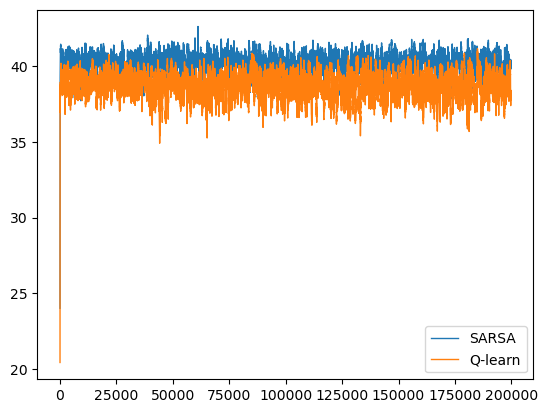

In [6]:
iters = 200000
(rewards_sarsa,rewards_qlearn),(best_qs_qlearn,best_qs_sarsa),(best_ps_qlearn,best_ps_sarsa) = gather_data(iters,[1,100,1000,iters-1])

# Plot reward convergence
window_width = 200
cumsum_vec_sarsa = np.cumsum(np.insert(rewards_sarsa, 0, 0))
ma_vec_sarsa = (cumsum_vec_sarsa[window_width:] - cumsum_vec_sarsa[:-window_width]) / window_width

cumsum_vec_qlearn = np.cumsum(np.insert(rewards_qlearn, 0, 0))
ma_vec_qlearn = (cumsum_vec_qlearn[window_width:] - cumsum_vec_qlearn[:-window_width]) / window_width

plt.plot(range(len(ma_vec_sarsa)),ma_vec_sarsa,label = "SARSA",linewidth=1)
plt.plot(range(len(ma_vec_qlearn)),ma_vec_qlearn,label = "Q-learn",linewidth=1)
plt.legend()
plt.show()

SARSA: Heatmaps and arrowmaps

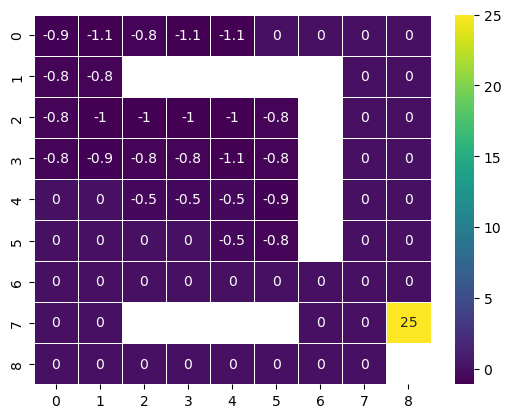

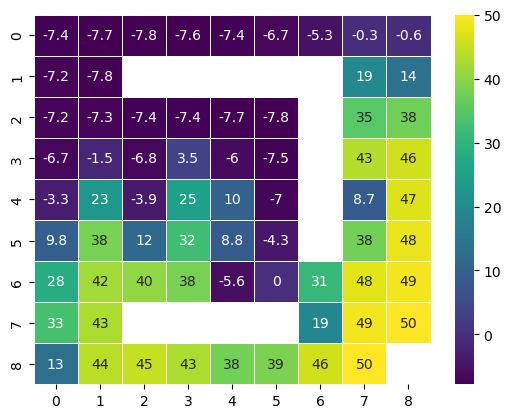

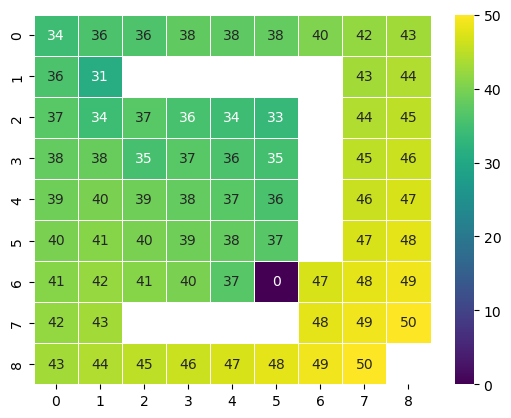

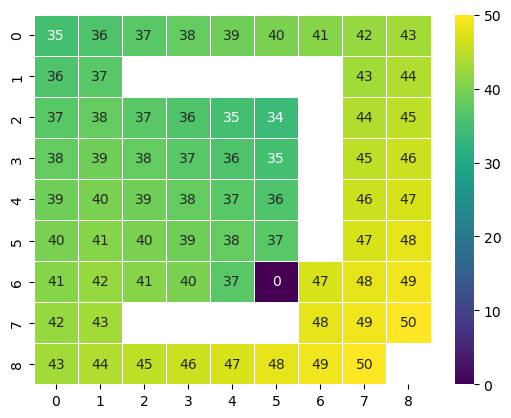

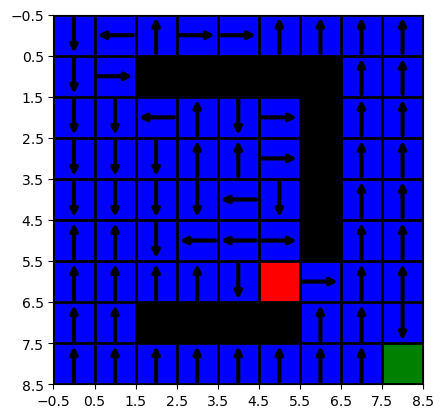

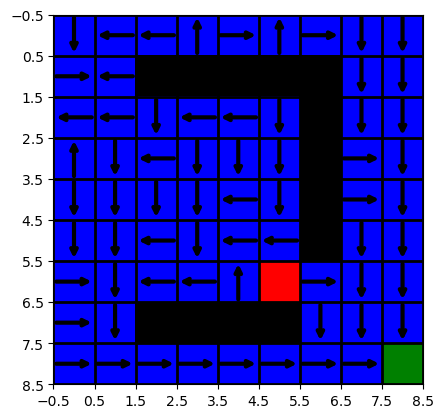

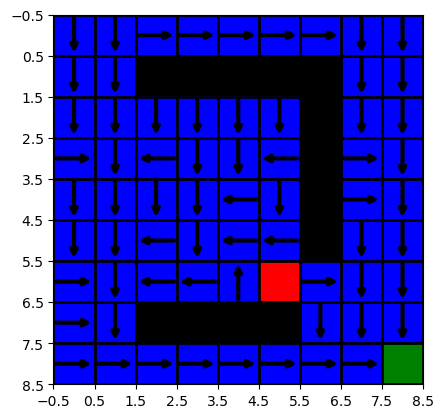

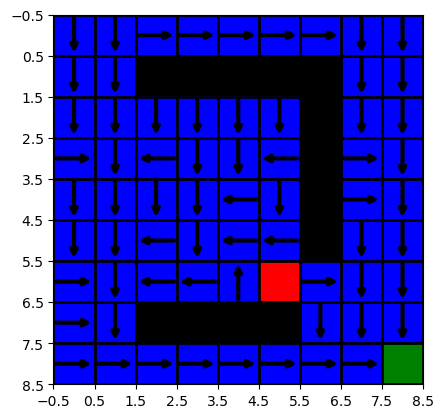

In [7]:
for i in range(len(best_qs_sarsa)):
    show_heatmap(best_qs_sarsa[i])


for i in range(len(best_ps_sarsa)):
    create_arrowmap(best_ps_sarsa[i])


Q-Learning: Heatmaps and arrowmaps

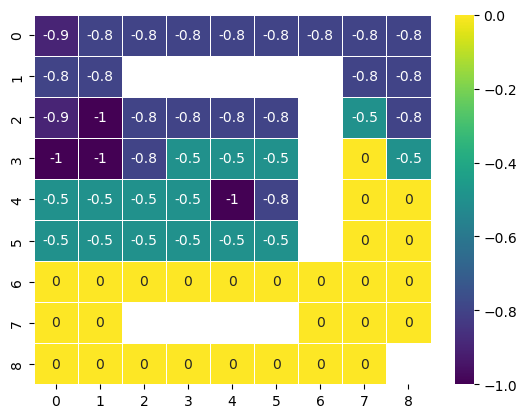

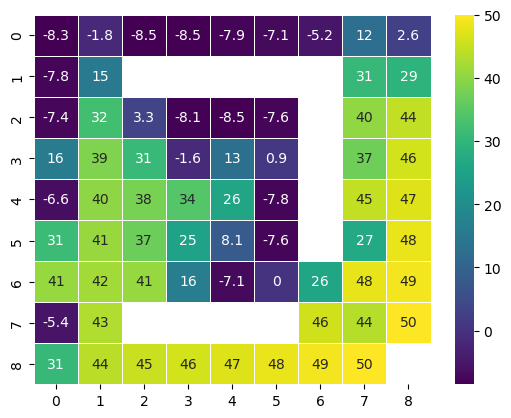

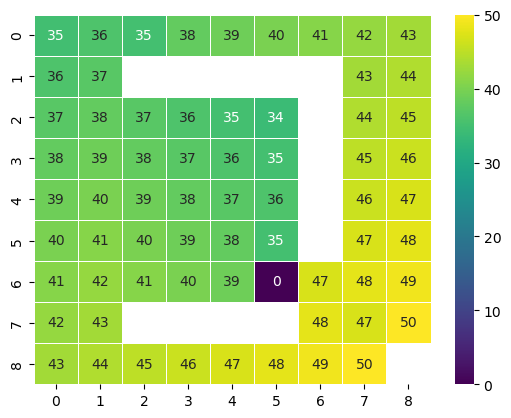

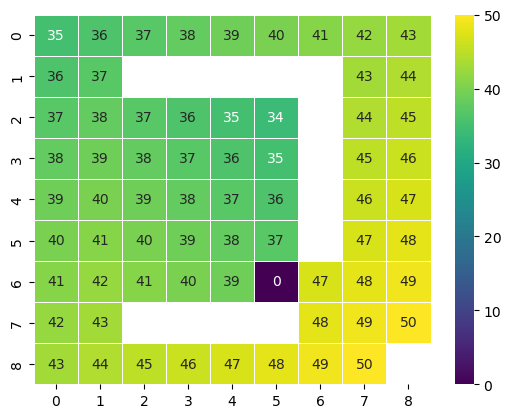

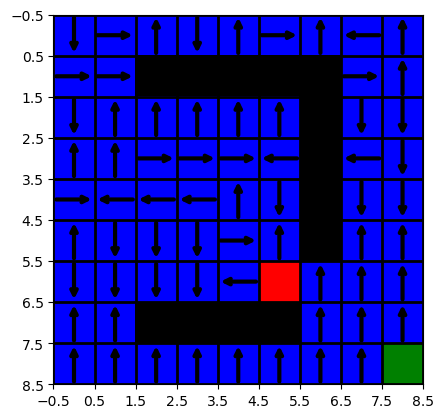

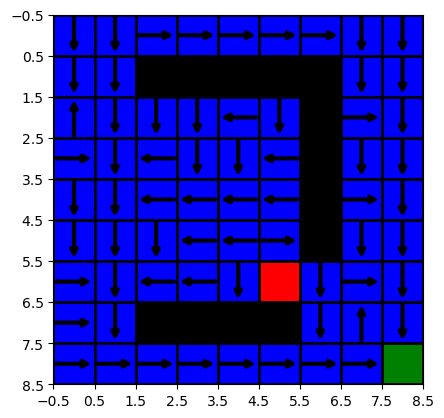

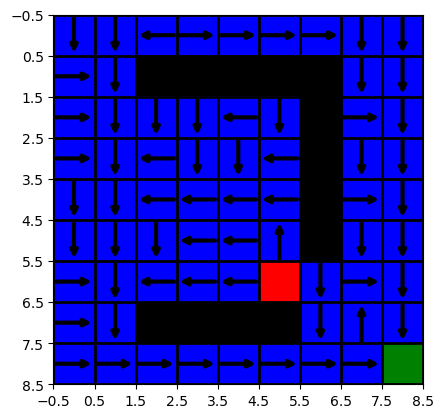

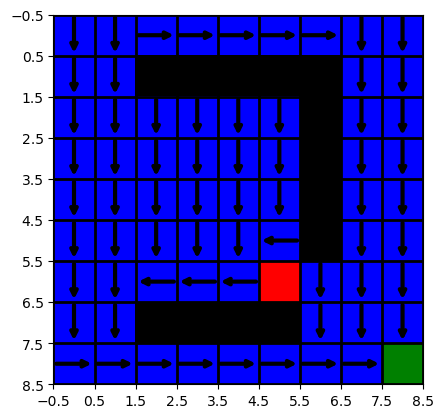

In [9]:
for i in range(len(best_qs_qlearn)):
    show_heatmap(best_qs_qlearn[i])
    

for i in range(len(best_ps_qlearn)):
    create_arrowmap(best_ps_qlearn[i])
